In [1]:
!curl https://raw.githubusercontent.com/ggonzalesd/Deep-Learning-Project/dev/brain_tumor_dataset.py --output brain_tumor_dataset.py
!curl https://raw.githubusercontent.com/ggonzalesd/Deep-Learning-Project/dev/trainer.py --output trainer.py
!curl https://raw.githubusercontent.com/ggonzalesd/Deep-Learning-Project/dev/classification_models.py --output classification_models.py
!curl https://raw.githubusercontent.com/ggonzalesd/Deep-Learning-Project/dev/classification_models2.py --output classification_models2.py
!curl https://raw.githubusercontent.com/ggonzalesd/Deep-Learning-Project/dev/classification_models3.py --output classification_models3.py
!curl https://raw.githubusercontent.com/ggonzalesd/Deep-Learning-Project/dev/classification_models4.py --output classification_models4.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   640  100   640    0     0   2612      0 --:--:-- --:--:-- --:--:--  2612
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4358  100  4358    0     0  23430      0 --:--:-- --:--:-- --:--:-- 23430
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6336  100  6336    0     0  30171      0 --:--:-- --:--:-- --:--:-- 30028
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3952  100  3952    0     0  21362      0 --:--:-- --:--:-- --:--:-- 21362
  % Total    % Received % Xferd  Average Speed   Tim

## Import modules

In [2]:
import h5py                                           # Read .Mat Files
import random                                         # Get random integers
import pandas as pd                                   # Read CSV
import numpy as np                                    # Transform and save arrays
from skimage.draw import polygon                      # Create images from points

import torch                                          # Framework
from torch import optim                               # optim: Adam, SDG
from torch import nn

from torch.utils import data                          # Data
from torchvision import transforms                    # Transform dataset images

import matplotlib.pyplot as plt                       # Visualize images and more

from brain_tumor_dataset import BrainTumorDataset     # Dataset
from classification_models import InceptionModel
#from classification_models2 import HighParamCnnWithSELU
#from classification_models3 import CNNWithFiveLayerLeakyReLU
#from classification_models4 import MultiLayerSeLU
from trainer import Trainer, ModelCheckpoint          # Trainer Class

## Preprocessing Dataset | (from .mat to .npy)

Download and unzip dataset

In [ ]:
!curl https://figshare.com/ndownloader/articles/1512427/versions/5 --output data.zip
!mkdir tmp_dataset
!mkdir dataset
!unzip data.zip -d ./tmp_dataset
!for file in ./tmp_dataset/*.zip; do unzip $file -d ./tmp_dataset/; done
!rm ./tmp_dataset/*.zip

Convert .mat to .npy

In [4]:
data_tmp = {'image':[], 'label':[]}
index = 0
for i in range(3064):
  with h5py.File(f"tmp_dataset/{i+1}.mat", 'r') as f:
    img = np.array(f.get('cjdata/image'), dtype=np.float32)
    if img.shape == (512, 512):
      border = np.array(f.get('cjdata/tumorBorder')).reshape((-1, 2))
      name = f"{index+1}.npy"
      img = img / img.max()

      mask = np.zeros_like(img, dtype=np.float32)
      rr, cc = polygon(border[:,0], border[:,1], img.shape)
      mask[rr,cc] = 1.0

      result = np.stack([img, mask], axis=2)

      np.save("./dataset/"+name, result)
      data_tmp['image'].append(name)
      data_tmp['label'].append(np.array(f.get('cjdata/label'), dtype=np.int64).item()-1)
      index += 1

Save labels in a CSV file

In [5]:
df = pd.DataFrame(data_tmp)
df.to_csv('./dataset/data.csv', index=False)
df.head()
del df, data_tmp

Remove MAT files

In [6]:
!rm -rf tmp_dataset

## Functions Tools

In [7]:
def split_dataset(dataset, train_size=0.8):
  n = len(dataset)
  n_train = int(n*train_size)
  n_val = n - n_train
  train_dataset, val_dataset = data.random_split(dataset, [n_train, n_val])
  return train_dataset, val_dataset

def plot_train_loss(model_dic, label=None, legend='upper center', model_name=None):
  """
     This method allows you to view the history of the loss function per epoch
  """
  train_loss_history = model_dic['train_loss_history']
  x_values = range(1, len(train_loss_history) + 1)
  plt.figure(figsize=(7, 5))
  if model_name is None:
    plt.title('Training loss')
  else:
    plt.title('Training loss using ' + model_name)

  if label is not None:
    plt.plot(x_values, train_loss_history, '-o', label=label)
    plt.legend(loc=legend)
  else:
    plt.plot(x_values, train_loss_history, '-o')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

def plot_accuracy(model_dic, model_name=None):
  """
     This method allows you to view the historical accuracy per epoch
  """  
  train_acc_history = model_dic['train_acc_history']
  val_acc_history = model_dic['val_acc_history']
  x_values = range(1, len(train_acc_history) + 1)
  plt.figure(figsize=(7, 5))
  if model_name is None:
    plt.title('Accuracy')
  else:
    plt.title('Accuracy using ' + model_name )
  plt.plot(x_values, train_acc_history, '-o', label='train')
  plt.plot(x_values, val_acc_history, '-o', label='val')
  plt.ylabel('Accuracy')  
  plt.xlabel('Epoch')
  plt.legend(loc='lower right')
  plt.show()

def plot_metric_from_array(models_dic, plot_name, legend='lower right', plot_data='both', metric='acc'):
  """
     This method allows to visualize the history of the validation 
     accuracy of several models per epoch
  """
  if metric not in ['acc', 'loss']:
    raise ValueError(f"metric:'{metric}' is not a valid value, use: 'acc', 'loss'")
  name = 'accuracy' if metric == 'acc' else 'loss'

  if plot_data == 'both':
    plt.subplots(figsize =(12, 5)) 
    ### Training subplot
    plt.subplot(1, 2, 1) 
  else:
    plt.figure(figsize=(7, 5))

  if plot_data == 'both' or plot_data == 'train':
    for model_name, model_dic in models_dic.items():
      train_acc_history = model_dic['train_'+metric+'_history']
      x_values = range(1, len(train_acc_history) + 1)	  
      if plot_name is None:
        plt.title('Training '+name)
      else:
        plt.title('Training '+name+' using ' + plot_name )
      plt.plot(x_values, train_acc_history, '-o', label=model_name)
    plt.ylabel(name.capitalize())
    plt.xlabel('Epoch')
    plt.legend(loc=legend)

  if plot_data == 'both':
    ### Validation subplot
    plt.subplot(1, 2, 2)  
  if plot_data == 'both' or plot_data == 'val':  
    for model_name, model_dic in models_dic.items():
      val_acc_history = model_dic['val_'+metric+'_history']
      x_values = range(1, len(val_acc_history) + 1)	  
      if plot_name is None:
        plt.title('Validation '+name)
      else:
        plt.title('Validation '+name+' using ' + plot_name )
      plt.plot(x_values, val_acc_history, '-o', label=model_name)   
    if plot_data == 'val':
      plt.ylabel(name.capitalize()) 
    plt.xlabel('Epoch')
    plt.legend(loc=legend)
  plt.show()

## Config GPU and Seed

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using {}'.format(device))

Using cuda


In [9]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

## Load Dataset and Create DataLoaders

In [10]:
# Load Dataset
dataset = BrainTumorDataset(
  csv_file='dataset/data.csv',
  root_dir='dataset',
  transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
  ])
)

train_data, test_data = split_dataset(dataset)
len(train_data), len(test_data)

(2439, 610)

In [11]:
# Split train_data for training and validation
train_set, val_set = split_dataset(train_data, train_size=0.75)

print('Original dataset size: ', len(dataset))
print('---------------------------')
print('Training data size: ', len(train_set))
print('Validation data size: ', len(val_set))
print('Test data size: ', len(test_data))

Original dataset size:  3049
---------------------------
Training data size:  1829
Validation data size:  610
Test data size:  610


In [12]:
# Create Loaders
train_dataloader = data.DataLoader(train_set, batch_size=32, shuffle=True)
val_dataloader = data.DataLoader(val_set, batch_size=32, shuffle=False)
test_dataloader = data.DataLoader(test_data, batch_size=32, shuffle=False)

print('Number of batches')
print('---------------------')
print('Training data: ', len(train_dataloader))
print('Validation data: ', len(val_dataloader))
print('Test data: ', len(test_dataloader))

Number of batches
---------------------
Training data:  58
Validation data:  20
Test data:  20


## View Dataset

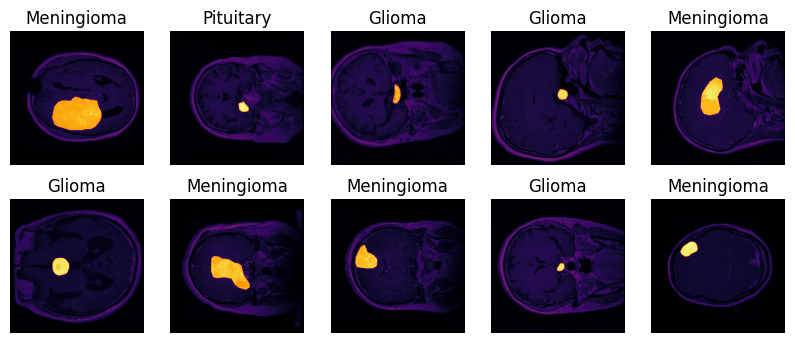

In [13]:
labels = ['Meningioma', 'Glioma', 'Pituitary']
plt.figure(figsize=(10, 4))
for i in range(10):
  index = random.randint(0, len(train_data)-1)
  image, label = train_data[index]
  image = (image*0.5 + 0.5).numpy()
  
  mask = 0.5*image[0,:,:] + image[1,:,:]

  plt.subplot(2, 5, i+1)
  plt.axis('off')
  plt.title(str(labels[label.item()-1]))
  plt.imshow(mask, cmap='inferno')

### Training

In [14]:
model = InceptionModel()
optimizer = optim.Adam(model.parameters(), 0.01)

epochs = 35
inception_model = Trainer.train(
  train_dataloader, val_dataloader, model,
  optimizer, device, epochs,
  ModelCheckpoint(verbose=True)
)

Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:11<00:00,  1.77it/s]



Epoch (1/35): train_loss = 0.492059, val_loss= 0.000174, train_acc = 0.799891, val_acc= 0.873770

Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:11<00:00,  1.75it/s]



Epoch (2/35): train_loss = 0.320882, val_loss= 0.000051, train_acc = 0.883543, val_acc= 0.875410

val_loss changed (0.000174 -> 0.000051). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.23it/s]



Epoch (3/35): train_loss = 0.244973, val_loss= 0.000159, train_acc = 0.911427, val_acc= 0.929508



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.47it/s]



Epoch (4/35): train_loss = 0.223734, val_loss= 0.000131, train_acc = 0.915801, val_acc= 0.909836



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.47it/s]



Epoch (5/35): train_loss = 0.203686, val_loss= 0.000192, train_acc = 0.920722, val_acc= 0.924590



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.11it/s]



Epoch (6/35): train_loss = 0.214002, val_loss= 0.000061, train_acc = 0.929470, val_acc= 0.955738



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.48it/s]



Epoch (7/35): train_loss = 0.171262, val_loss= 0.000026, train_acc = 0.935484, val_acc= 0.937705

val_loss changed (0.000051 -> 0.000026). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.52it/s]



Epoch (8/35): train_loss = 0.138569, val_loss= 0.000029, train_acc = 0.952980, val_acc= 0.936066



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.52it/s]



Epoch (9/35): train_loss = 0.133583, val_loss= 0.000048, train_acc = 0.956260, val_acc= 0.954098



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.39it/s]



Epoch (10/35): train_loss = 0.151332, val_loss= 0.000026, train_acc = 0.945872, val_acc= 0.955738

val_loss changed (0.000026 -> 0.000026). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.30it/s]



Epoch (11/35): train_loss = 0.169230, val_loss= 0.000127, train_acc = 0.936031, val_acc= 0.947541



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:04<00:00,  4.88it/s]



Epoch (12/35): train_loss = 0.117019, val_loss= 0.000002, train_acc = 0.955714, val_acc= 0.947541

val_loss changed (0.000026 -> 0.000002). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.21it/s]



Epoch (13/35): train_loss = 0.131837, val_loss= 0.000015, train_acc = 0.951886, val_acc= 0.940984



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.45it/s]



Epoch (14/35): train_loss = 0.090316, val_loss= 0.000008, train_acc = 0.965555, val_acc= 0.955738



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.49it/s]



Epoch (15/35): train_loss = 0.084199, val_loss= 0.000007, train_acc = 0.971569, val_acc= 0.965574



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.49it/s]



Epoch (16/35): train_loss = 0.166091, val_loss= 0.000009, train_acc = 0.948059, val_acc= 0.937705



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.44it/s]



Epoch (17/35): train_loss = 0.133558, val_loss= 0.000012, train_acc = 0.949699, val_acc= 0.963934



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:04<00:00,  4.69it/s]



Epoch (18/35): train_loss = 0.083432, val_loss= 0.000002, train_acc = 0.971569, val_acc= 0.940984

val_loss changed (0.000002 -> 0.000002). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.26it/s]



Epoch (19/35): train_loss = 0.101400, val_loss= 0.000001, train_acc = 0.965008, val_acc= 0.954098

val_loss changed (0.000002 -> 0.000001). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.43it/s]



Epoch (20/35): train_loss = 0.086282, val_loss= 0.000008, train_acc = 0.970476, val_acc= 0.936066



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.48it/s]



Epoch (21/35): train_loss = 0.148356, val_loss= 0.000008, train_acc = 0.954620, val_acc= 0.942623



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.43it/s]



Epoch (22/35): train_loss = 0.108269, val_loss= 0.000012, train_acc = 0.955714, val_acc= 0.949180



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.35it/s]



Epoch (23/35): train_loss = 0.044477, val_loss= 0.000001, train_acc = 0.986878, val_acc= 0.967213

val_loss changed (0.000001 -> 0.000001). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.13it/s]



Epoch (24/35): train_loss = 0.050851, val_loss= 0.000002, train_acc = 0.981411, val_acc= 0.963934



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.11it/s]



Epoch (25/35): train_loss = 0.062301, val_loss= 0.000001, train_acc = 0.980317, val_acc= 0.955738



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.45it/s]



Epoch (26/35): train_loss = 0.027891, val_loss= 0.000002, train_acc = 0.988518, val_acc= 0.962295



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.51it/s]



Epoch (27/35): train_loss = 0.068111, val_loss= 0.000003, train_acc = 0.974850, val_acc= 0.957377



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.52it/s]



Epoch (28/35): train_loss = 0.043016, val_loss= 0.000000, train_acc = 0.981957, val_acc= 0.972131

val_loss changed (0.000001 -> 0.000000). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.46it/s]



Epoch (29/35): train_loss = 0.022899, val_loss= 0.000000, train_acc = 0.991252, val_acc= 0.981967



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.46it/s]



Epoch (30/35): train_loss = 0.027427, val_loss= 0.000000, train_acc = 0.989612, val_acc= 0.960656

val_loss changed (0.000000 -> 0.000000). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.13it/s]



Epoch (31/35): train_loss = 0.099363, val_loss= 0.000010, train_acc = 0.965008, val_acc= 0.957377



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:04<00:00,  4.67it/s]



Epoch (32/35): train_loss = 0.082070, val_loss= 0.000001, train_acc = 0.973209, val_acc= 0.947541



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.45it/s]



Epoch (33/35): train_loss = 0.060994, val_loss= 0.000001, train_acc = 0.975943, val_acc= 0.970492



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.50it/s]



Epoch (34/35): train_loss = 0.020140, val_loss= 0.000000, train_acc = 0.992346, val_acc= 0.965574



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.42it/s]


Epoch (35/35): train_loss = 0.041809, val_loss= 0.000001, train_acc = 0.984691, val_acc= 0.955738



<ipython-input-7-10f1849b0732>:60: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


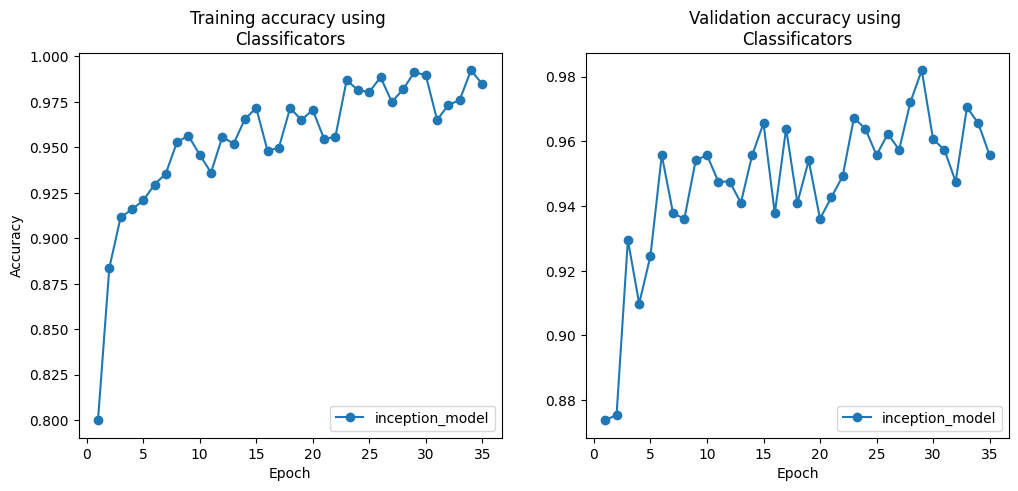

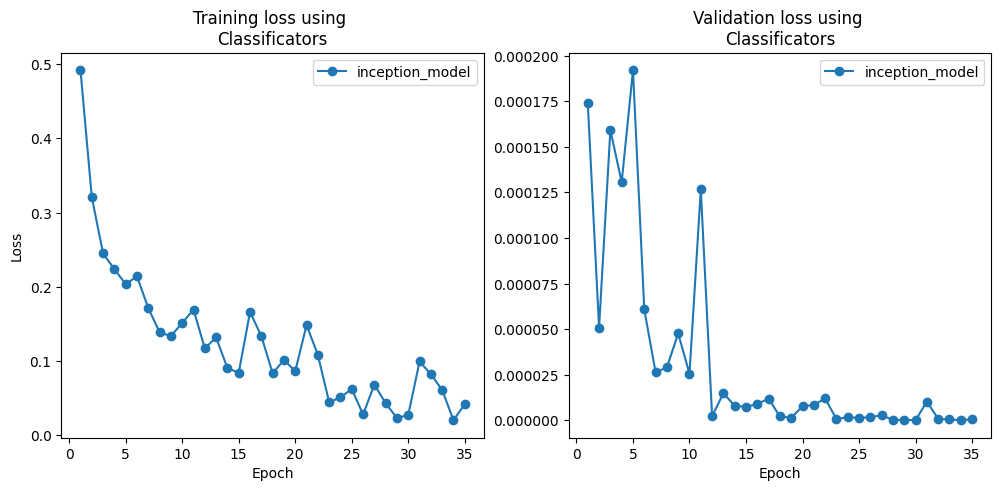

In [15]:
info = {
    'inception_model': inception_model
}

plot_metric_from_array(info, '\nClassificators')
plot_metric_from_array(info, '\nClassificators', metric='loss', legend='upper right')